By Seong-Eun Cho

For the data project, I decided to use the General Conference audio as my dataset. The advantages of using this data is that the speech has minimal background noise and large amounts of data are readily available. Also, because I'm also scraping the dubbings of all other audio supported languages, there are variety of languages that have different phonemes, and many different speaker. 
The downside of this dataset is precisely that there are less noise and the environment is very limited, so many of the vocabularies will be repeated and all data will be controlled. Also, for a specific language, the speaker will have very little variety. However, since the problem we're tackling is difficult itself, the inherent "clean" nature of this dataset will ease the machine learning process.

I first scraped the data from LDS.org for a specified interval of years, which I chose to be 2016-2018. This means that I downloaded all of the talks between 2016 to 2018 for all possible languages. This added up to around 100GB of mp3 audio. Then, in order for ease of use in Python, I resampled all data from 44.1kHz to 16kHz and converted the files to .wav files which increased the size by 4 times in average (so ~400GB total). I was able to accomplish this using a simple sox command:
sox input/mp3/audio/file -r 16000 output/wav/audio/file

At this point, I had to figure out a way to clean the data, which mostly includes splitting the audio files into small ~5 second intervals of audio. I accomplished this by using the SoundWave object that we made in last year's Fourier transform lab and adding a "split" method.

In [2]:
class SoundWave(object):
        # ...
    def split(self, time_frame=0.2, min_len=5, stride=10):
        min_len*=self.rate
        window = int(self.rate * time_frame)
        pause = False
        start = []
        stop = []
        loop = tqdm(total=len(self.samples)//stride - window, position=0, leave=False)
        for i in range(len(self.samples)//stride - window):
            j = i*stride
            if not pause:
                if np.abs(self.samples[j:j+window]).max() <= self.bound:
                    start.append(j)
                    pause = True
            else:
                if np.abs(self.samples[j:j+window]).max() > self.bound:
                    stop.append(j+window)
                    pause = False
            loop.update(1)
        loop.close()
        if len(start) > len(stop):
            stop.append(len(self.samples) - 1)
        
        ti = np.vstack([start, stop]).mean(axis=0).astype(int)
        sample_splits = []
        left = ti[0]
        for i in range(len(ti) - 1):
            sample_len = ti[i + 1] - left
            if sample_len < min_len:
                continue
                print("bad", left, ti[i+1])
            else:
                current_sample = SoundWave(self.rate, self.samples[left:ti[i+1]])
                sample_splits.append(current_sample)
                left = ti[i+1]
        return sample_splits
        # ...

In [3]:
rate, wave = wavfile.read("/Users/Seong-EunCho/Desktop/BYU/2018 Fall/acmeproject/sample/2018-10-1010-russell-m-nelson-64k-eng.wav")
S = SoundWave(rate, wave)

Below is a plot of the whole audio.

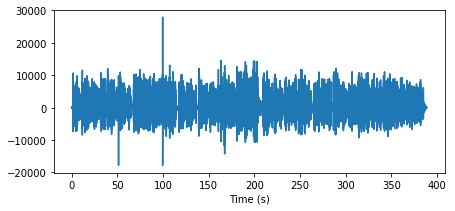

In [11]:
S.plot()

Below is the plot of a few smaller chunks of audio

In [6]:
splits = S.split(time_frame=0.2, min_len=3)

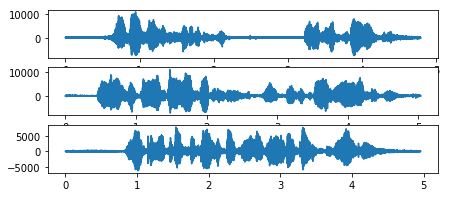

The splitting was done by using the following method:

First, I set a epilson bound for the decibal which would detect when there would be pauses and speech. I found that the best bound was set by some constant times the mean of the samples ($C\hat{\mu}$) where $C$ was around 1.5 to 2.

Then a keyword arguments time_frame, min_len, stride was passed into the function. time_frame describes a width of a sliding window that would determine whether a given window constitutes as a pause, min_len is the minimum length a chunck of audio can take, and stride describes the number of samples it skips as the window slides across the audio (stride greatly increases speed).

The algorithm for determining a pause is simple: If in a given window of audio, the maximum of the samples is lower than the bound, then that window is a pause. I simply cut the audio during the middle of the pause to split the long audio into smaller chunks. This was the main bulk of the cleaning process.